# Anomaly Detection with GANs for Multivariate Time Series
https://arxiv.org/pdf/1809.04758.pdf

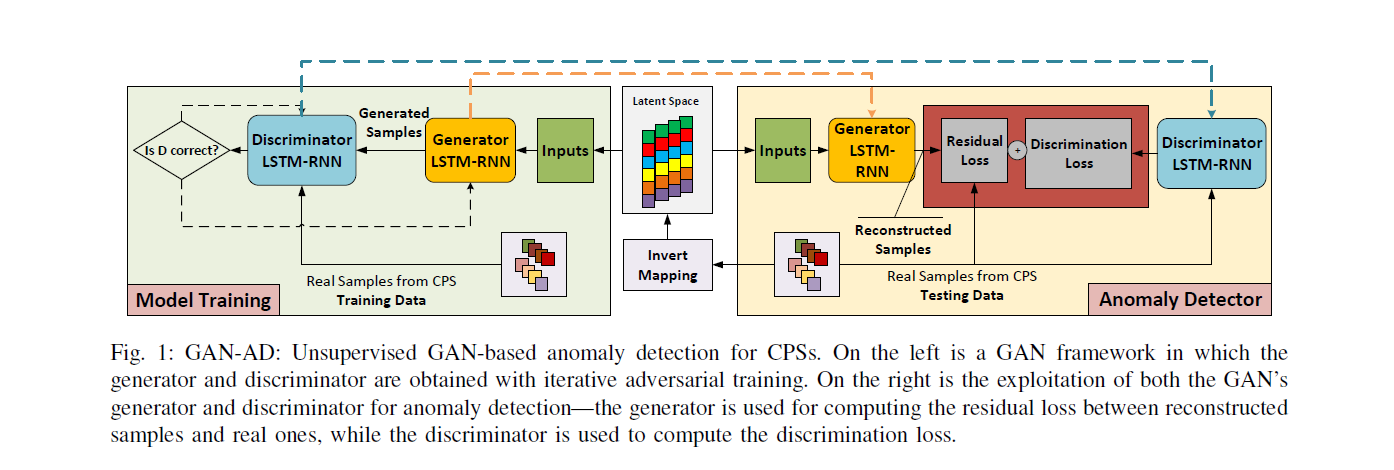

In [1]:
import os
import pandas as pd
import numpy as np
from time_series_anomaly_detection.detector import GAN_AD
import random
from datetime import date
import matplotlib.pyplot as plt

# Skoltech Anomaly Benchmark (SKAB) dataset
https://github.com/waico/SKAB

## Load and split data

In [2]:
# single multivariate time series
df_anomaly_free = pd.read_csv("../datasets/skab/anomaly-free/anomaly-free.csv", index_col='datetime', sep=';',parse_dates=True).reset_index(drop=True)

In [3]:
ratio = 0.75
split = int(len(df_anomaly_free)*ratio)
df_anomaly_free, df_test = df_anomaly_free.iloc[:split,:].reset_index(drop=True), df_anomaly_free.iloc[split:,:].reset_index(drop=True)

In [4]:
df_anomaly_free.describe()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
count,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,0.211477,0.269542,2.532384,0.111784,89.700982,28.138902,228.435041,124.765474
std,0.004761,0.004007,5.341825,0.253411,0.648544,0.672366,12.242058,1.731301
min,0.198511,0.260767,0.855284,-0.929070,88.546100,26.765800,1.336380,118.000000
25%,0.209461,0.266371,2.129020,0.054711,89.213800,27.600425,222.478000,123.335000
50%,0.212496,0.268205,2.545025,0.054711,89.579700,28.271000,228.886000,125.331000
75%,0.214572,0.273093,2.731903,0.382638,90.152500,28.702025,234.830250,126.000000
max,0.222114,0.280214,230.819000,1.366420,91.724900,29.075200,252.806000,128.351000


In [5]:
ratio = 0.5
split = int(len(df_test)*ratio)
df_anomaly_free_test, df_with_anomalies = df_test.iloc[:split,:].reset_index(drop=True), df_test.iloc[split:,:].reset_index(drop=True)

In [6]:
# insert dummy fake anomalies
random.seed(10)
anomaly_index = random.sample(range(0, df_with_anomalies.shape[0]), int(0.2*df_with_anomalies.shape[0]))
df_with_anomalies.iloc[anomaly_index, [0,1,4]] = df_with_anomalies.iloc[anomaly_index, [0,1,4]] * 0.95
df_with_anomalies.iloc[anomaly_index, [2,6]] = df_with_anomalies.iloc[anomaly_index, [2,6]] * 1.1
df_with_anomalies.describe()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,0.211770,0.264146,2.662389,0.108529,87.907734,29.342310,233.377190,126.050878
std,0.005607,0.006155,7.388220,0.247501,1.793900,0.041834,15.718574,0.669431
min,0.186048,0.246563,0.893839,-0.601143,83.839780,29.247400,2.611422,123.000000
25%,0.209330,0.262810,2.172702,0.054711,88.403150,29.322000,225.114000,125.677000
50%,0.212274,0.265243,2.573680,0.054711,88.634350,29.343700,231.399500,126.000000
75%,0.215435,0.267920,2.797279,0.382638,88.980650,29.354700,242.537000,126.677000
max,0.225967,0.276206,255.230800,0.710565,89.538500,29.522100,276.999800,127.678000


In [7]:
df_anomalies_labels = df_with_anomalies.copy()
df_anomalies_labels['label'] = 0
df_anomalies_labels.iloc[anomaly_index, :] = 1
df_anomalies_labels = df_anomalies_labels.drop(columns=['Accelerometer1RMS','Accelerometer2RMS','Current','Pressure','Temperature','Thermocouple','Voltage','Volume Flow RateRMS'])

## Model's parameters settings

In [8]:
# values selected based on experiments
window_size = 16
shift = 5
batch_size = 32
latent_dim = 2 
n_features = df_anomaly_free.shape[1]

## Training

In [9]:
gan_ad = GAN_AD(window_size, shift, batch_size, latent_dim, n_features)
gan_ad.fit(df_anomaly_free, 10000, save_checkpoints=True, enable_prints=True)
# gan_ad.save_model("gan_ad_" + str(date.today()) + ".h5")

KeyboardInterrupt: 

## Loading best weights

7000 . epoch

Batch loss (disc_loss, gen_loss) : [0.21547717 3.9397886 ]

7500 . epoch

Batch loss (disc_loss, gen_loss) : [0.05491132 4.837315  ]

8000 . epoch

Batch loss (disc_loss, gen_loss) : [0.34914508 3.4787216 ]

8500 . epoch

Batch loss (disc_loss, gen_loss) : [0.80346507 2.6210155 ]

9000 . epoch

Batch loss (disc_loss, gen_loss) : [0.2298915 3.904429 ]

In [10]:
gan_ad.load_weights("gan_ad_2021-05-01_epoch_9000.h5")
gan_ad.fit_scaler(df_anomaly_free)

## Evaluation

### Anomaly free (training) data

In [21]:
# less than one window
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free[0:0+window_size-5]))

Not enough data to predict anomaly scores.


loss celkovo:  0.38785137859834684
loss celkovo:  0.050367905219601945
final loss:  0.04991930442384182
[[-0.733839452 -0.804118276]
 [0.437859714 0.739214599]
 [-0.615812778 -0.00874312595]
 ...
 [6.25004101 0.206783563]
 [-0.232924461 0.222491711]
 [-2.01635957 -1.23613143]]
sample


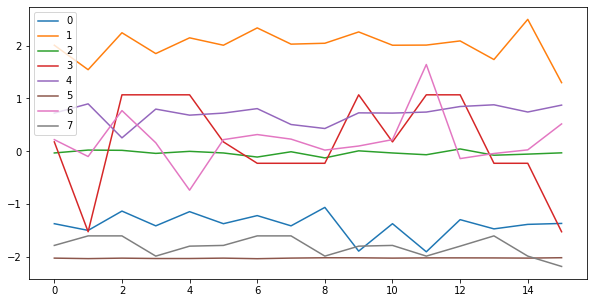

generated_sample


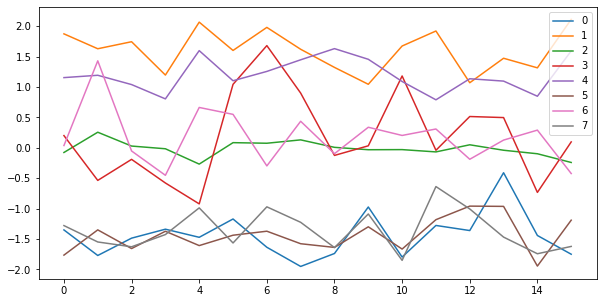

residuals: 
tf.Tensor(
[1.5835245  4.12670586 4.12199746 4.21697236 6.20298856 3.08144731
 5.21137092 4.1694288  3.66283216 5.58267827 2.57596797 5.37451824
 3.82572763 3.63661173 2.47285171 6.06599657], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.7711934], shape=(1,), dtype=float32)
Anomaly free (training) data with NaNs - anomaly scores


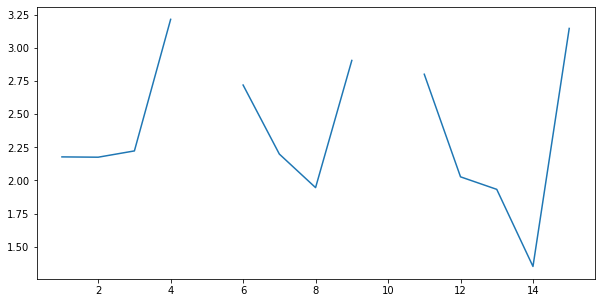

In [22]:
# one window with NaN values
window_with_nan = pd.DataFrame(df_anomaly_free[0:0+window_size].copy())
window_with_nan.iloc[[0,5,10], [2,5]] = np.nan
# display(windows_with_nan)

anomaly_scores = gan_ad.predict_anomaly_scores(window_with_nan)
print('Anomaly free (training) data with NaNs - anomaly scores')
plt.figure(figsize=(10,5))
plt.plot(anomaly_scores)
plt.show()

Ignoring last 8 samples (incomplete window).
loss celkovo:  0.25383922494121264
loss celkovo:  0.10659867489764159
loss celkovo:  0.076946657489809722
loss celkovo:  0.076009507988588576
loss celkovo:  0.076006986616655267
final loss:  0.077947811015862234
[[-1.98076165 -2.31642914]
 [-0.614756644 1.10670924]
 [-2.81949568 -0.22898677]
 ...
 [2.14849877 0.0125804804]
 [0.0810992122 -2.19077659]
 [-8.40362835 1.35389173]]
sample


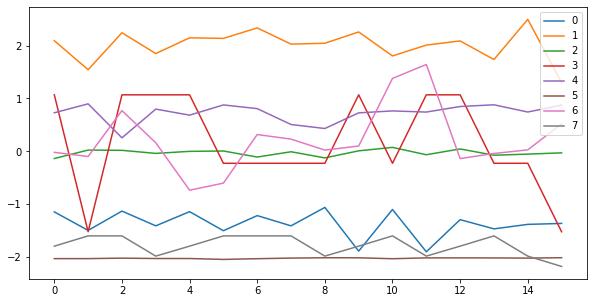

generated_sample


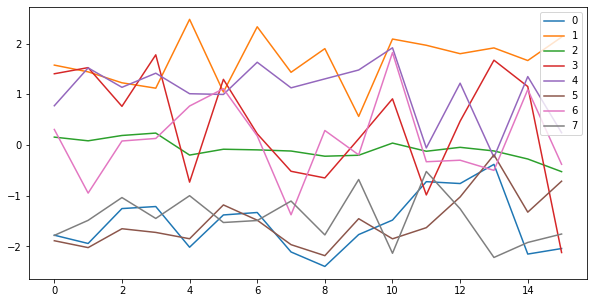

residuals: 
tf.Tensor(
[2.29359561 5.24033843 4.11786227 3.38641718 6.00305206 5.57814299
 2.19232202 4.47121462 3.51364333 5.68890468 4.15033508 7.94529282
 3.56662791 7.22343607 5.62202877 5.85400003], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.6530538], shape=(1,), dtype=float32)
loss celkovo:  0.29740750660974491
loss celkovo:  0.053967507681173088
loss celkovo:  0.053967422209995654
loss celkovo:  0.053967345269649705
loss celkovo:  0.053967253018044892
final loss:  0.053592104720849812
[[-1.27161407 -0.835547209]
 [0.170916766 0.517898202]
 [0.672143221 -0.236587107]
 ...
 [1.66968346 -1.43107355]
 [-0.289665431 0.862520695]
 [-0.152336687 -1.32006752]]
sample


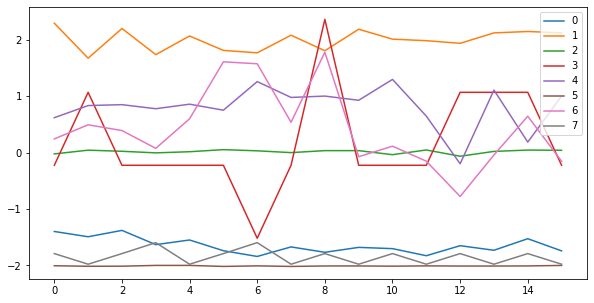

generated_sample


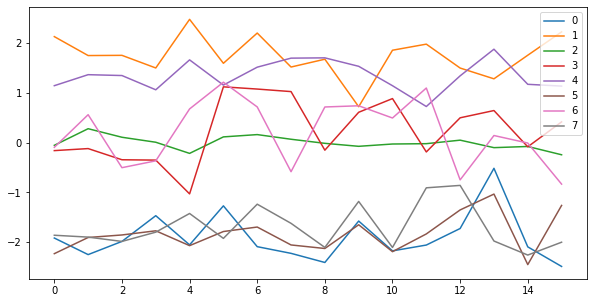

residuals: 
tf.Tensor(
[1.92859907 3.04865296 2.99805267 1.69734421 3.44869267 3.26444086
 5.19260097 4.66532752 5.52235739 5.0959973  2.76806466 2.91624481
 4.36257682 4.54112253 4.7730416  3.34157012], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.7421988], shape=(1,), dtype=float32)
Anomaly free (training) data - anomaly scores


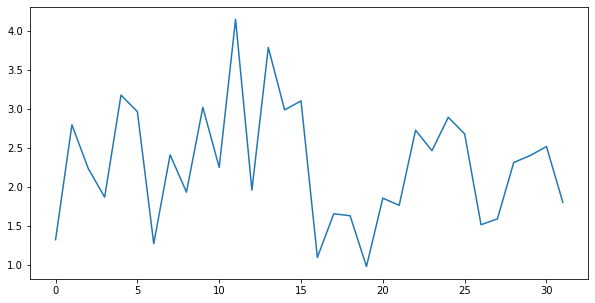

In [23]:
# more than one window
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free[0:0+(2*window_size)+8]))
print('Anomaly free (training) data - anomaly scores')
plt.figure(figsize=(10,5))
plt.plot(anomaly_scores)
plt.show()

### Anomaly free (test) data

loss celkovo:  0.11379971383672657
loss celkovo:  0.078513768271707
loss celkovo:  0.078513001375380864
loss celkovo:  0.07851230342572757
loss celkovo:  0.0785116622233844
final loss:  0.078391607366680827
[[-0.54503119 0.786801]
 [0.799780488 -0.254521132]
 [-0.60690695 0.74977231]
 ...
 [-0.777936578 3.09713602]
 [-5.84682178 4.45694447]
 [-2.16005802 -1.83922887]]
sample


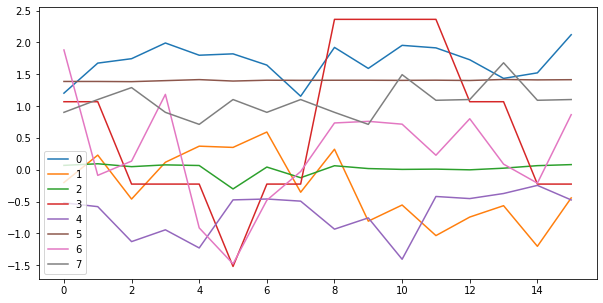

generated_sample


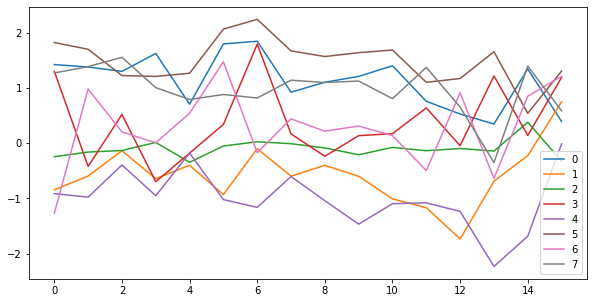

residuals: 
tf.Tensor(
[5.74788388 4.92554891 2.9213396  3.14733218 5.0556976  7.80676725
 4.85121527 1.85997644 5.27682484 4.8513052  5.14389491 5.13656736
 4.98074074 6.38015112 5.50768408 6.17425165], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.69693315], shape=(1,), dtype=float32)
loss celkovo:  0.0937294557328137
loss celkovo:  0.072494295686086063
loss celkovo:  0.069663570509369319
loss celkovo:  0.066404055079813451
loss celkovo:  0.066403926213462666
final loss:  0.066116957871055038
[[0.464750141 1.79493856]
 [-0.293084711 -0.800741553]
 [0.744026184 0.238843262]
 ...
 [-4.10920572 4.03473663]
 [15.8681765 -1.20768285]
 [-10.8396959 4.25927639]]
sample


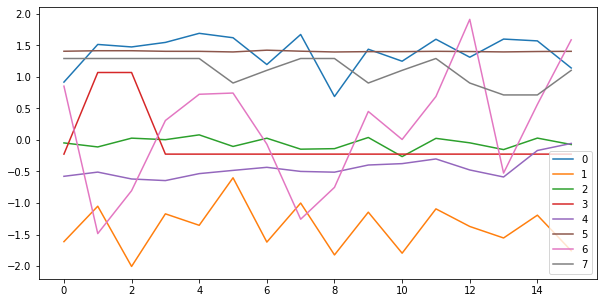

generated_sample


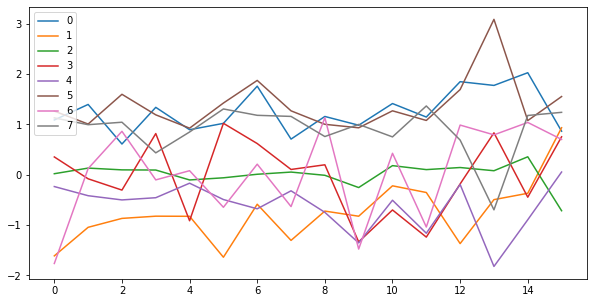

residuals: 
tf.Tensor(
[4.07843514 3.92322062 5.66218315 3.35856413 4.13060767 4.7594609
 3.50346176 2.8712908  5.16488629 5.62883904 3.69251035 5.2712826
 2.48152842 8.17594624 3.82024604 5.86551528], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.57136023], shape=(1,), dtype=float32)
loss celkovo:  0.17420002999912335
loss celkovo:  0.080493202972710357
loss celkovo:  0.078944001313764486
loss celkovo:  0.078943829121420478
loss celkovo:  0.078943656673836765
final loss:  0.078952853919878621
[[-0.732482195 0.252592146]
 [0.137244567 -1.15126646]
 [-0.10146381 1.06492162]
 ...
 [-2.69427 0.39178288]
 [-2.68136573 1.20452595]
 [6.43496513 9.46518707]]
sample


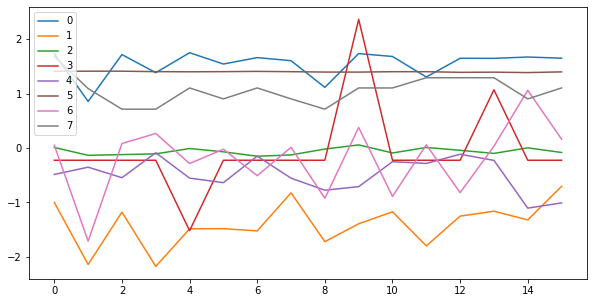

generated_sample


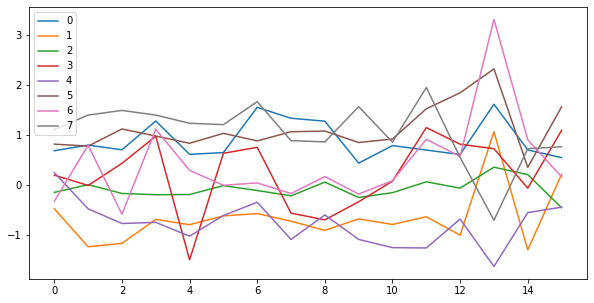

residuals: 
tf.Tensor(
[ 4.43313824  4.88094521  3.69781947  5.49168539  3.77677312  3.37835914
  3.90327688  1.89471457  3.241012    6.97558636  4.35742495  5.78500679
  5.49662458 10.65019805  3.27965637  4.77331555], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.5727034], shape=(1,), dtype=float32)
Anomaly free (test) data - anomaly scores


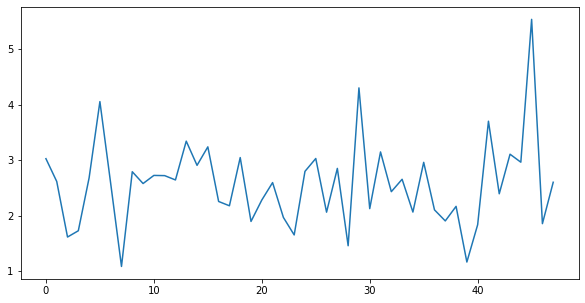

In [24]:
# more than one window
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free_test[0:0+window_size*3]))
print('Anomaly free (test) data - anomaly scores')
plt.figure(figsize=(10,5))
plt.plot(anomaly_scores)
plt.show()

### Data with (inserted) anomalies

Original data with anomalies


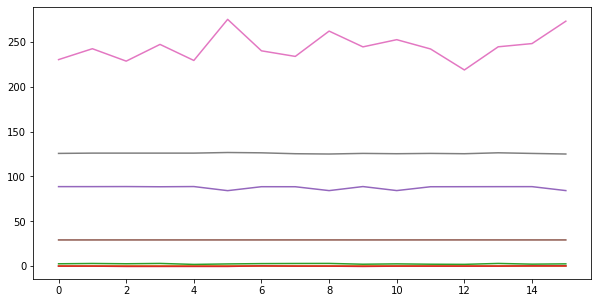

Scaled data with anomalies - true anomalies


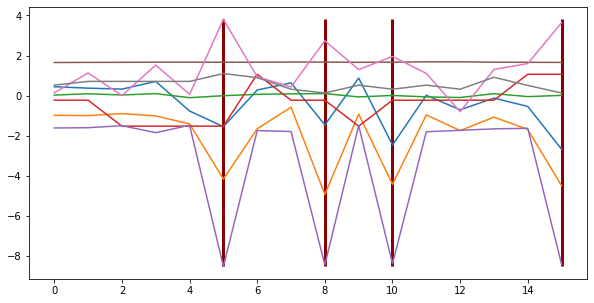

Scaled data with anomalies - predicted anomaly scores
loss celkovo:  0.12850673139738455
loss celkovo:  0.085450448821367
loss celkovo:  0.085449982226066437
loss celkovo:  0.085449919043066522
loss celkovo:  0.085449857344435276
final loss:  0.084505183107327547
[[0.296759486 0.414734185]
 [-0.0898114368 0.534526765]
 [-0.22910288 0.953905404]
 ...
 [-2.02703357 4.67011547]
 [-7.37835264 3.47066259]
 [-1.57710922 0.559431]]
sample


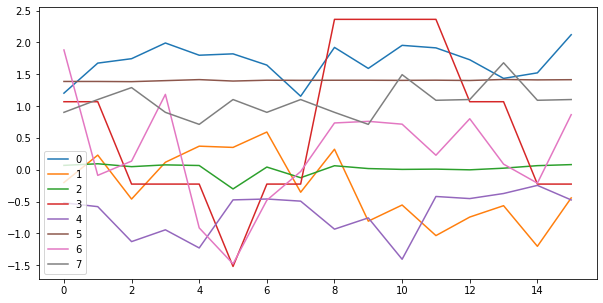

generated_sample


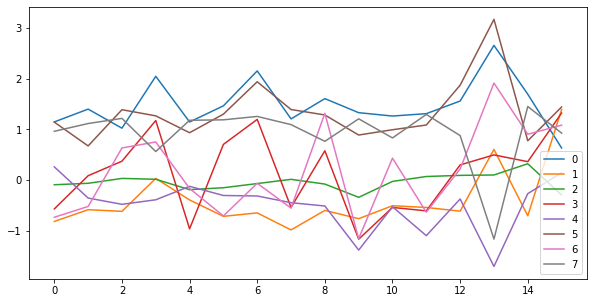

residuals: 
tf.Tensor(
[ 6.18188249  3.62360444  2.71777451  3.06589616  5.2166422   4.90881073
  4.73170653  1.73682845  4.43231216  7.7636405   5.91520659  6.19914311
  2.51629986 10.80495836  3.64652368  6.28444337], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.5975742], shape=(1,), dtype=float32)


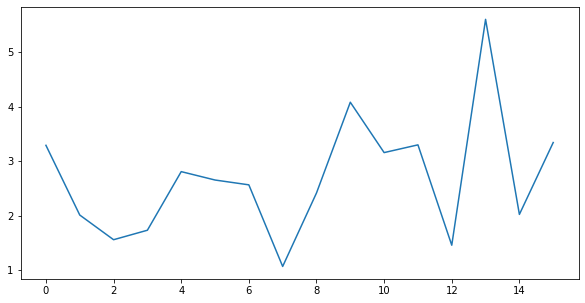

Scaled data with anomalies - predicted anomalies
loss celkovo:  0.63925674743804306
loss celkovo:  0.22542132137749893
loss celkovo:  0.22542103817192183
loss celkovo:  0.22542075314871754
loss celkovo:  0.22542047586194155
final loss:  0.22462616241727651
[[-0.77629596 0.0076168552]
 [0.305513769 -0.544862032]
 [-0.0968679786 1.13542604]
 ...
 [0.617813885 -0.000295404345]
 [0.645796239 -0.165570706]
 [2.23167062 -0.019970879]]
sample


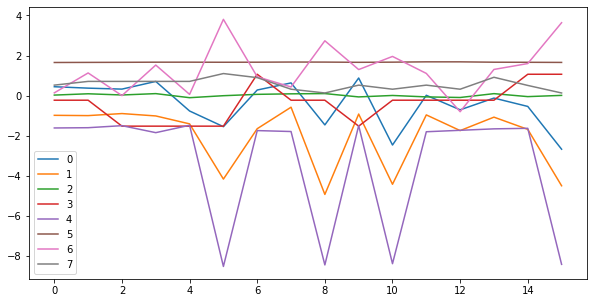

generated_sample


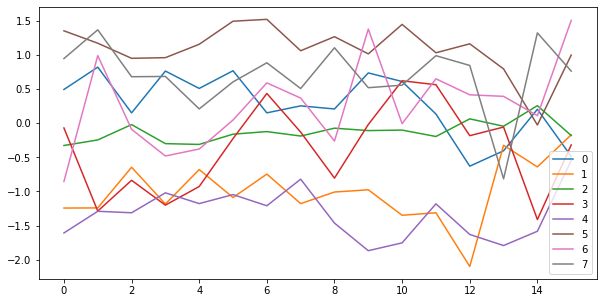

residuals: 
tf.Tensor(
[ 2.54182635  3.68932076  2.19048751  4.52206575  4.56476962 18.74463619
  2.91298468  3.19847751 17.6918176   2.86277001 16.14993372  3.58754878
  2.9844654   5.01121609  8.60079389 19.3795342 ], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.7045814], shape=(1,), dtype=float32)
anomaly_score
0     1.418622
1     1.992370
2     1.242953
3     2.408742
4     2.430094
5     9.520027
6     1.604202
7     1.746948
8     8.993618
9     1.579094
10    8.222676
11    1.941484
12    1.639942
13    2.653317
14    4.448106
15    9.837476
dtype: float64
cross_entropy
0     0.349686
1     0.689325
2     0.217490
3     0.879105
4     0.887930
5     2.253398
6     0.472626
7     0.557870
8     2.196515
9     0.456851
10    2.106896
11    0.663452
12    0.494661
13    0.975811
14    1.492478
15    2.286199
dtype: float64


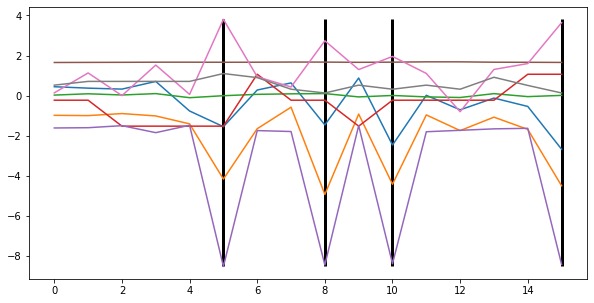

In [25]:
# one window
print('Original data with anomalies')
data = pd.DataFrame(df_with_anomalies[0:0+window_size])
plt.figure(figsize=(10,5))
plt.plot(data)
plt.show()

print('Scaled data with anomalies - true anomalies')
data = gan_ad.transform_data(pd.DataFrame(df_with_anomalies[0:0+window_size]))
plt.figure(figsize=(10,5))
plt.plot(data)
labels = pd.DataFrame(df_anomalies_labels[0:0+window_size]).replace(0,np.nan).dropna().index
plt.vlines(x=labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='darkred', ls='-', lw=3, label='vline_single - full height')
plt.show()

print('Scaled data with anomalies - predicted anomaly scores')
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free_test[0:0+window_size]))
plt.figure(figsize=(10,5))
plt.plot(anomaly_scores)
plt.show()

print('Scaled data with anomalies - predicted anomalies')
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[0:0+window_size]), treshold = 2)
predicted_labels = pd.DataFrame(predicted).replace(0,np.nan).dropna().index
plt.figure(figsize=(10,5))
plt.plot(data)
plt.vlines(x=predicted_labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='black', ls='-', lw=3, label='vline_single - full height')
plt.show()

Original data with anomalies


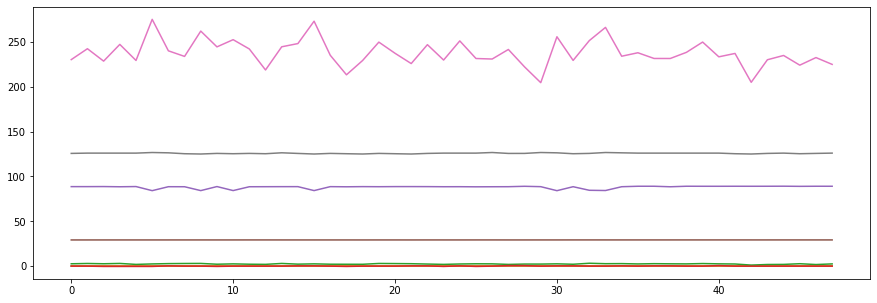

Scaled data with anomalies - true anomalies


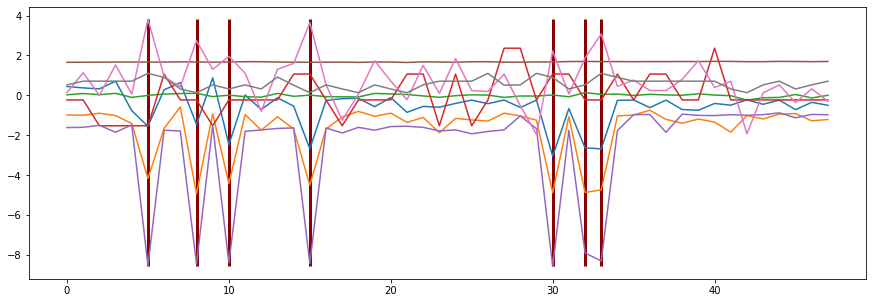

Scaled data with anomalies - predicted anomaly scores
loss celkovo:  0.18112507500373137
loss celkovo:  0.077544891943606975
loss celkovo:  0.077544733677919309
loss celkovo:  0.077544570906760035
loss celkovo:  0.077544412952330943
final loss:  0.077483888963458245
[[0.986152649 0.494916677]
 [0.311537921 0.298097908]
 [-0.809965611 -0.953256965]
 ...
 [-1.32223809 0.0673188]
 [-0.850668907 1.29111457]
 [-2.45537972 2.41145086]]
sample


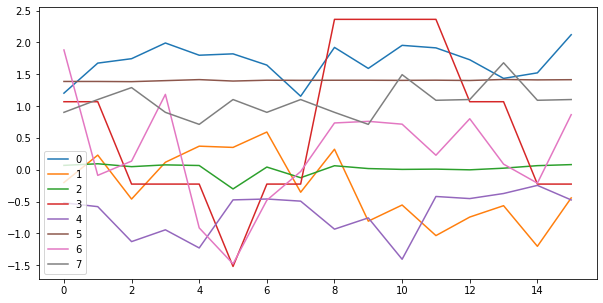

generated_sample


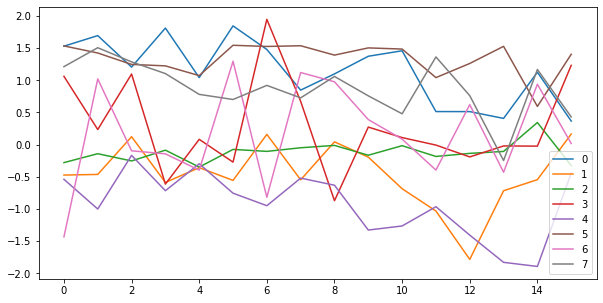

residuals: 
tf.Tensor(
[4.74314686 3.7507096  4.08342083 3.36742071 4.06845343 6.01424069
 3.88253387 3.15905384 5.12826149 4.18915737 4.76916698 5.7704624
 5.26239933 6.40458608 5.2284205  5.78634687], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.6920469], shape=(1,), dtype=float32)
loss celkovo:  0.5134464638873385
loss celkovo:  0.073472137710056923
loss celkovo:  0.071269308002153725
loss celkovo:  0.071268989502111191
loss celkovo:  0.071268677116187659
final loss:  0.071131681897264848
[[-0.867005467 0.864661]
 [-0.231061727 -1.0756377]
 [1.17511737 -0.153458819]
 ...
 [-0.956154823 -0.211268216]
 [-6.183465 1.64425385]
 [7.45187569 10.7612476]]
sample


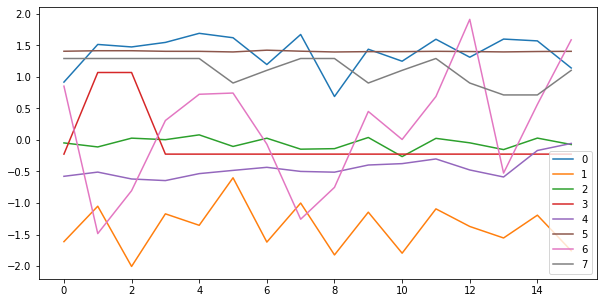

generated_sample


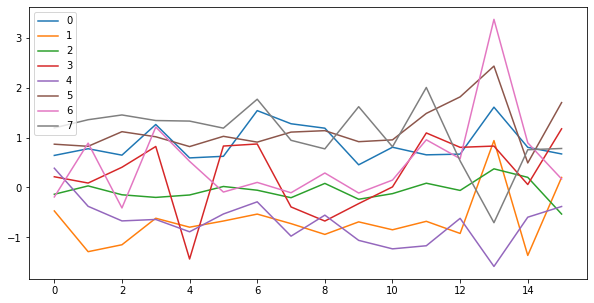

residuals: 
tf.Tensor(
[ 4.58389068  5.25966237  3.42522684  3.43497286  4.27270911  3.78748107
  4.10711801  3.16216459  3.90887834  4.23780113  3.49350006  4.66719336
  4.39823019 11.44419434  3.10820966  6.64833758], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.53296006], shape=(1,), dtype=float32)
loss celkovo:  0.096794488004644019
loss celkovo:  0.079318278138854448
loss celkovo:  0.078834036258925544
loss celkovo:  0.0788339625838534
loss celkovo:  0.078833895430763
final loss:  0.078873953962490251
[[-0.296235383 -0.318392307]
 [-1.84706569 0.607324958]
 [2.17322421 -0.419721067]
 ...
 [-1.57896078 0.569001675]
 [-3.62511206 1.3122009]
 [6.70451927 9.24700737]]
sample


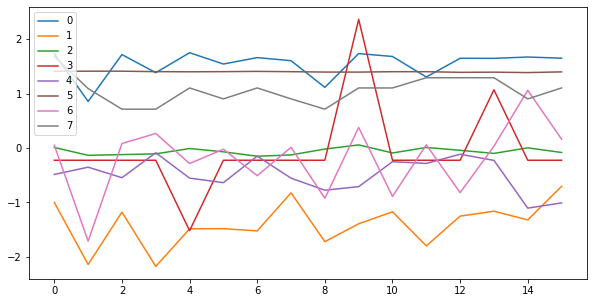

generated_sample


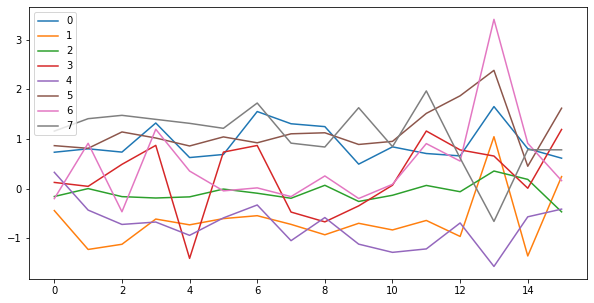

residuals: 
tf.Tensor(
[ 4.21089049  4.99107637  3.55184198  5.38104491  3.92957201  3.49528893
  4.04200445  1.70165095  3.2157843   6.98480883  4.23608382  5.75851286
  5.41097899 10.73337992  3.05874679  4.92568181], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.56709164], shape=(1,), dtype=float32)


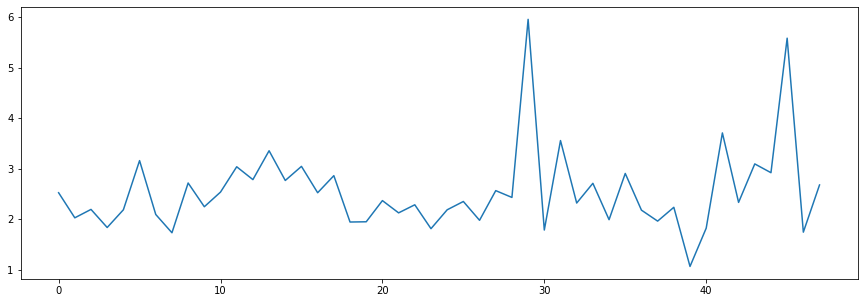

Scaled data with anomalies - predicted anomalies
loss celkovo:  0.26644574491757983
loss celkovo:  0.22471046950111828
loss celkovo:  0.22471032214752479
loss celkovo:  0.22471017619060443
loss celkovo:  0.22471002790529798
final loss:  0.22427872161719981
[[-0.104869843 -0.151905447]
 [-0.812557578 0.0715309083]
 [-0.5137012 0.875186086]
 ...
 [0.123633057 -1.43824923]
 [0.714807451 -2.59681392]
 [1.53885603 0.241807625]]
sample


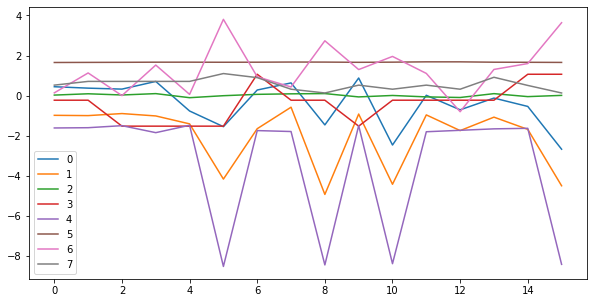

generated_sample


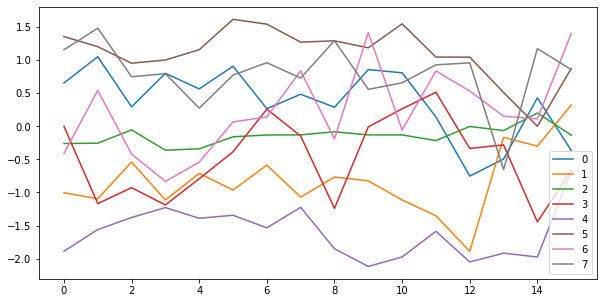

residuals: 
tf.Tensor(
[ 2.51133213  3.92654466  2.35271387  4.71576839  4.63300925 18.23181034
  3.27810824  2.72648971 18.16193304  2.94786524 16.07874592  2.93828671
  3.33090862  5.65474646  9.27726423 20.48289351], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.6983386], shape=(1,), dtype=float32)
loss celkovo:  0.18659608674457479
loss celkovo:  0.12488063580782857
loss celkovo:  0.12253712305460074
loss celkovo:  0.12064393694257042
loss celkovo:  0.11828538631171687
final loss:  0.11506930361701523
[[0.0363727473 -0.244582832]
 [-0.150241196 0.586916447]
 [-0.0460160188 0.122368932]
 ...
 [2.35507512 -0.646379054]
 [5.18977594 -0.450465918]
 [1.76983654 1.54416645]]
sample


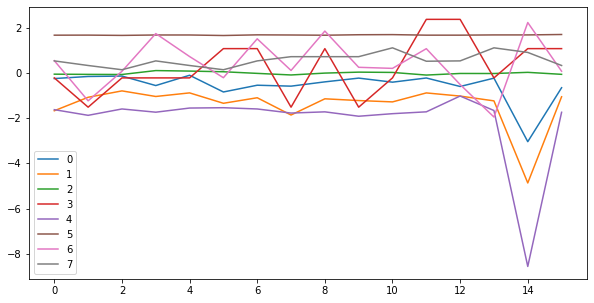

generated_sample


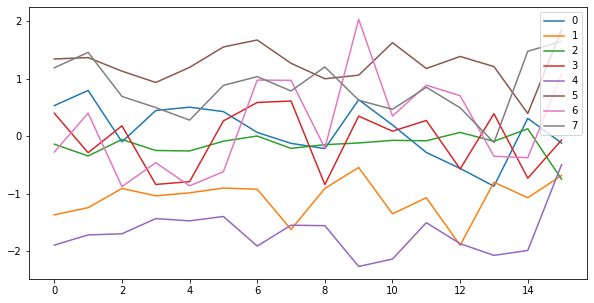

residuals: 
tf.Tensor(
[ 3.86277865  5.85902932  2.70265555  5.25309861  3.80188875  4.04597552
  2.65674753  4.52513951  5.84566495  6.41401452  2.26322559  3.57349315
  6.32514114  5.44302807 20.08485978  6.4762378 ], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.39148843], shape=(1,), dtype=float32)
loss celkovo:  0.19439896142731344
loss celkovo:  0.17012699825843225
loss celkovo:  0.16374627087337174
loss celkovo:  0.14908037326796186
loss celkovo:  0.13968638688913876
final loss:  0.13928208797056824
[[3.0538671 -3.51881695]
 [1.30987716 0.348681241]
 [-1.35375631 3.008111]
 ...
 [6.10518837 -13.0913734]
 [8.31179619 -4.03635836]
 [-7.57714319 22.2034874]]
sample


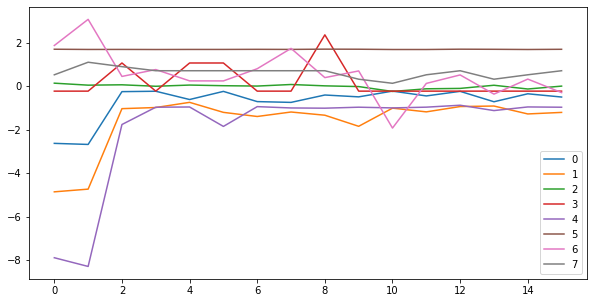

generated_sample


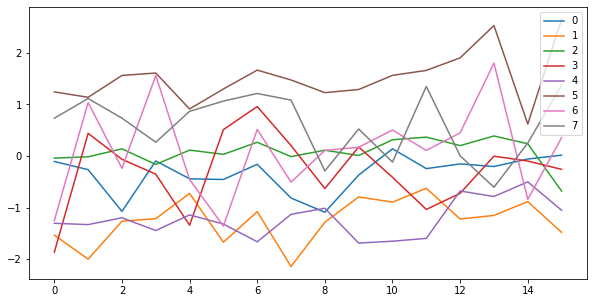

residuals: 
tf.Tensor(
[18.03735894 15.43451903  3.81129497  2.45434278  4.47516744  4.12707025
  3.8479301   4.50925743  5.59324836  3.46778007  4.67873151  3.55329248
  2.34049256  5.57146716  4.13933284  3.84774485], shape=(16,), dtype=float64)
real_prob
tf.Tensor([0.23904741], shape=(1,), dtype=float32)
anomaly_score
0      1.406497
1      2.114103
2      1.327188
3      2.508715
4      2.467335
5      9.266736
6      1.789885
7      1.514076
8      9.231797
9      1.624763
10     8.190204
11     1.619974
12     1.816285
13     2.978204
14     4.789463
15    10.392277
16     2.235645
17     3.233770
18     1.655584
19     2.930805
20     2.205200
21     2.327244
22     1.632630
23     2.566826
24     3.227088
25     3.511263
26     1.435869
27     2.091002
28     3.466826
29     3.025770
30    10.346686
31     3.542375
32     9.399156
33     8.097736
34     2.286124
35     1.607648
36     2.618060
37     2.444011
38     2.304441
39     2.635105
40     3.177100
41     2.114366
42   

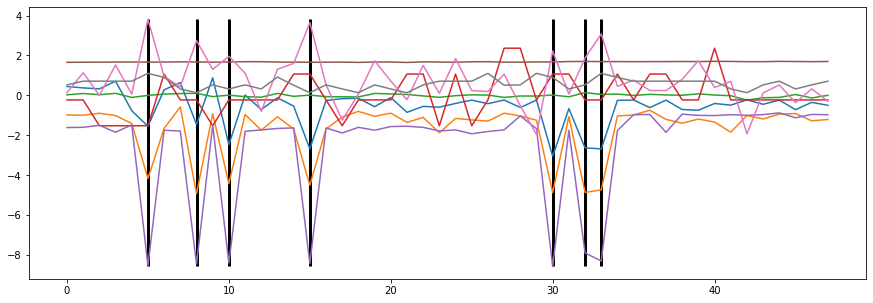

In [26]:
# more than one window
print('Original data with anomalies')
data = pd.DataFrame(df_with_anomalies[0:0+window_size*3])
plt.figure(figsize=(15,5))
plt.plot(data)
plt.show()

print('Scaled data with anomalies - true anomalies')
data = gan_ad.transform_data(pd.DataFrame(df_with_anomalies[0:0+window_size*3]))
plt.figure(figsize=(15,5))
plt.plot(data)
labels = pd.DataFrame(df_anomalies_labels[0:0+window_size*3]).replace(0,np.nan).dropna().index
plt.vlines(x=labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='darkred', ls='-', lw=3, label='vline_single - full height')
plt.show()

print('Scaled data with anomalies - predicted anomaly scores')
anomaly_scores = gan_ad.predict_anomaly_scores(pd.DataFrame(df_anomaly_free_test[0:0+window_size*3]))
plt.figure(figsize=(15,5))
plt.plot(anomaly_scores)
plt.show()


print('Scaled data with anomalies - predicted anomalies')
predicted = gan_ad.identify_anomaly(pd.DataFrame(df_with_anomalies[0:0+window_size*3]), treshold = 2)
predicted_labels = pd.DataFrame(predicted).replace(0,np.nan).dropna().index
plt.figure(figsize=(15,5))
plt.plot(data)
plt.vlines(x=predicted_labels, ymin=np.min(np.min(data)), ymax=np.max(np.max(data)), colors='black', ls='-', lw=3, label='vline_single - full height')
plt.show()